In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Pastel2.colors)
plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

NOTE. This notebook is for making a graph where I show how the computation time scales with the number of particles and the number of steps. The result is that it scales roughtly linearly with total steps yet is super linear when it comes to particle count. So a good lesson to accelerate the code is to batch particles into smaller groups when parallelizing. I launched 2640 simulations (165 GCs, 4NP, 4alpha). Not all of them are going to finish and I think I could be submitting them better with slurm. That's fine though to get the trend with comp time. This was computed on Tycho. However, I can't get latex on tycho for rendering the text in matplotlib so I'm exporting the data so I can make the graphs on local.

# Computation time

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$


In [2]:
ONTYCHO = False  # Set to True if running on Tycho, False otherwise

if ONTYCHO:
    path="/scratch2/sferrone/simulations/Stream/pouliasis2017pii/numericalErrorExperiment/"
    fnames=os.listdir(path)
    fnames = [f for f in fnames if f.endswith('.hdf5') ]
    NPs = [ ]
    NSTEPS = []
    comp = []
    errE = []
    taus = []
    alphas = []
    for i in range(0,len(fnames)):
        if np.mod(i,100) == 0:
            print(fnames[i], datetime.datetime.now())


        with h5py.File(path+fnames[i], 'r') as myfile:
            
            NSTEP = myfile['hostorbit'].shape[1]
            NP = myfile['streamfinal'].shape[1]
            comptimestream = myfile['comptimestream'][()]


            MWparams = myfile.attrs['potentialparams']
            hostparams = myfile.attrs['hostparams']
            phiMW,phiHost,T=STR.compute_stream_energy(MWparams,hostparams,myfile['hostorbit'][:,-1],myfile['streamfinal'][:])
            Estream = phiMW+phiHost+T
            phiMW,phiHost,T=STR.compute_stream_energy(MWparams,hostparams,myfile['hostorbit'][:,0],myfile['streaminitial'] + myfile['hostorbit'][:,0][:,np.newaxis])
            E0 = phiMW+phiHost+T
            
            tau=STR.plummer_dynamical_time(hostparams)
            dt = myfile.attrs['integrationparameters'][1]
            alpha=dt/tau        
            
            taus.append(tau)
            alphas.append(alpha)
            errE.append(np.abs((np.mean(Estream) - np.mean(E0)) / np.mean(E0)))
            NPs.append(NP)
            NSTEPS.append(NSTEP)
            comp.append(comptimestream)

    NPs = np.array(NPs)
    NSTEPS = np.array(NSTEPS)
    comp = np.array(comp)
    errE = np.array(errE)
    alphas = np.array(alphas)
    taus = np.array(taus)
    # SAVE THE DATA INTO A TXT
    np.savetxt('stream_computation_time.txt', np.array([NPs, NSTEPS, comp, errE, alphas, taus]).T, header='NPs NSTEPS comp errE', fmt='%d %d %.6f %.6f %.6f %.6f')
else:
    plt.rcParams.update({"text.usetex": True,})

In [3]:
# LOAD THE DATA FROM THE TXT
NPs, NSTEPS, comp, errE, alphas, taus = np.loadtxt('stream_computation_time.txt',
                               unpack=True, skiprows=1, dtype={'names': ('NPs', 'NSTEPS', 'comp', 'errE', 'alphas', 'taus'),
                                                                                 'formats': ('i4', 'i4', 'f8', 'f8', 'f8', 'f8')})

In [4]:
# fit the log of the time 
logNPS = np.log10(NPs)
logNSTEPS = np.log10(NSTEPS)
logcomp = np.log10(comp)

A = np.vstack([np.ones_like(logNPS), logNPS, logNSTEPS]).T
coeffs, residuals, rank, s = np.linalg.lstsq(A, logcomp, rcond=None)
logA, alpha, beta = coeffs

# Estimate variance of residuals
n = len(logcomp)
p = A.shape[1]
res_var = residuals[0] / (n - p) if residuals.size > 0 else 0

# Covariance matrix of coefficients
cov = res_var * np.linalg.inv(A.T @ A)
errors = np.sqrt(np.diag(cov))

logA_err, alpha_err, beta_err = errors

print(f"Fit: C = 10^{logA:.2f} ± {logA_err:.2f} * Np^{alpha:.2f} ± {alpha_err:.2f} * Nsteps^{beta:.2f} ± {beta_err:.2f}")


Fit: C = 10^-7.11 ± 0.04 * Np^1.35 ± 0.01 * Nsteps^0.95 ± 0.01


In [5]:
cmax = np.max(comp)
cmin = np.min(comp)
norm = mpl.colors.LogNorm(vmin=cmin, vmax=cmax)
cmap = mpl.cm.rainbow
colors = cmap(norm(comp))

# for printing the computation time in a nice format
boost=1
mantissa=10**(logA - int(logA) + boost)
exponent= int(logA) - boost
compstring = r"$\mathrm{{C}}(N_p,N_{{\mathrm{{steps}}}}) = {{{:.2f}}} \times 10^{{{:.0f}}}~\mathrm{{s}} \cdot N_p^{{{:.2f}}} \cdot N_{{\mathrm{{steps}}}}^{{{:.2f}}}$".format(mantissa,int(exponent), alpha, beta)


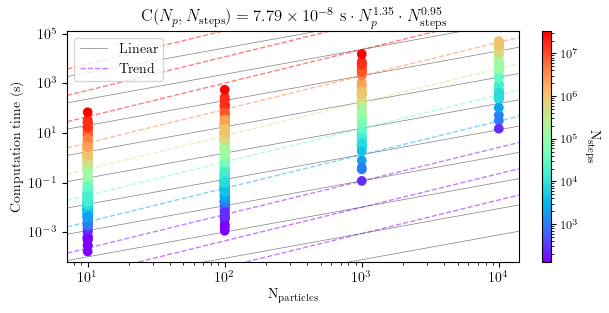

In [6]:
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=NSTEPS.min(), vmax=NSTEPS.max())
colors = cmap(norm(NSTEPS))
fig = plt.figure(figsize=(8.25-2,3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1/50], hspace=0.1, wspace=0.1)
axis= fig.add_subplot(gs[0, 0])
axis.scatter(NPs, comp,c=colors,zorder=10);
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlabel(r'$\mathrm{N}_{\mathrm{particles}}$')
axis.set_ylabel(r'$\mathrm{Computation~time~(s)}$')
xmin, xmax = axis.get_xlim()
ymin, ymax = axis.get_ylim()
# make some lines that use the fit 
xs = np.linspace(xmin, xmax, 10)

counter=0
for nstep in np.logspace(0,10, 10):
    compline = 10**(logA + alpha*np.log10(xs) + beta*np.log10(nstep))
    linear = 10**(logA + 1*np.log10(xs) + beta*np.log10(nstep))
    c = mpl.colors.to_hex(cmap(norm(nstep)))
    if counter == 0:
        axis.plot(xs, linear, color="k", linestyle='-', linewidth=0.5, alpha=0.5,zorder=0, label=r"$\mathrm{Linear}$")
        axis.plot(xs, compline, color=c, linestyle='--', linewidth=1, alpha=0.5,zorder=1, label=r"$\mathrm{Trend}$")
    else:
        axis.plot(xs, linear, color="k", linestyle='-', linewidth=0.5, alpha=0.5,zorder=0)
        axis.plot(xs, compline, color=c, linestyle='--', linewidth=1, alpha=0.5,zorder=1)
    counter += 1
axis.set_xlim(xmin, xmax)
axis.set_ylim(ymin, ymax)
axis.legend()
cax = fig.add_subplot(gs[0, 1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mathrm{N}_{\mathrm{steps}}$', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize="small")
axis.set_title(compstring, fontsize="large")
if not ONTYCHO:
    fig.savefig("../../images/NumericalErrorComputationTimeScalingForStreams.png", dpi=300, bbox_inches='tight')

# What's the numerical error for each? 

Two ways to look at this:
- 1. Pick an alpha, see the number of steps for each cluster. See how long it's gonna take for each
- 2. Pick a number of steps, see how long its gonna take, and then see the error spread in each. 


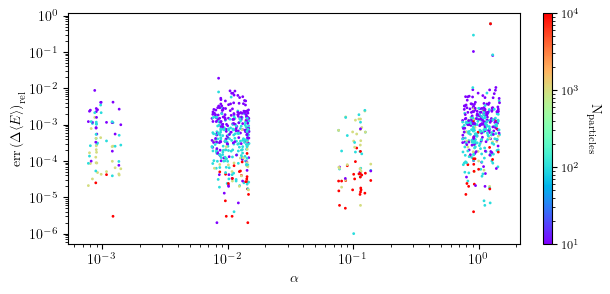

In [7]:
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=NPs.min(), vmax=NPs.max())
colors = cmap(norm(NPs))
fig=plt.figure(figsize=(8.25-2,3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1/50], hspace=0.1, wspace=0.1)
axis= fig.add_subplot(gs[0, 0])
axis.scatter(alphas, errE, c=colors, s=1);
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_xlabel(r'$\alpha$')
axis.set_ylabel(r'$\mathrm{err}\left(\Delta \langle E\rangle\right)_\mathrm{rel}$')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r'$\mathrm{N}_{\mathrm{particles}}$', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize="small")
if not ONTYCHO:
    fig.savefig("../../images/NumericalError_relative_mean_error_all_simulations.png", dpi=300, bbox_inches='tight')